In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

df_original = pd.read_csv('/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv').drop('index', axis=1)

df = df_original.copy()

df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [4]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])

# use 'duration' to represent transaction speed
df['duration'] = (df['lastSeen'] - df['dateCreated']).dt.days


# EDA

## 1. distribution of price

In [5]:
#check the range of price
df['price'].min(), df['price'].max()


(0, 2147483647)

In [6]:
#remove abnormal value
df = df[(df['price'] > 100) & (df['price'] < 150000)]
df['price'].min(), df['price'].max()

(101, 149999)

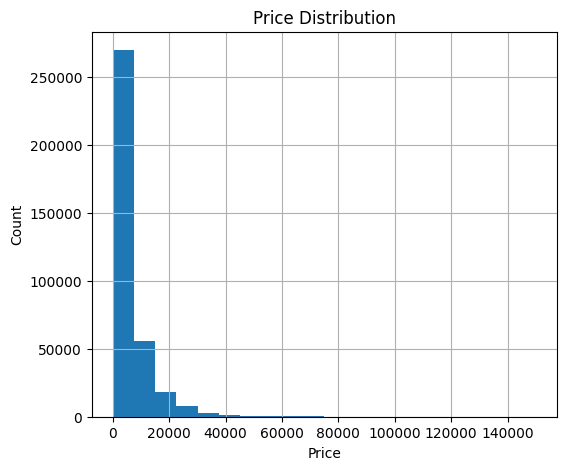

In [7]:
plt.figure(figsize=(6,5))
df['price'].hist(bins=20)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


## 2. distribution of kilometer driven

In [8]:
df['kilometer'].min(), df['kilometer'].max()

(5000, 150000)

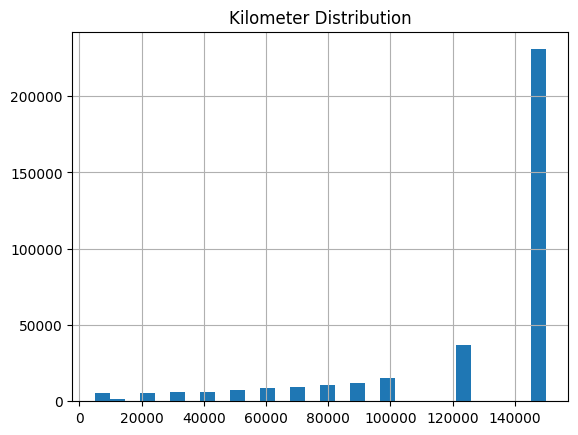

In [9]:
df['kilometer'].hist(bins=30)
plt.title("Kilometer Distribution")
plt.show()


## 3. yearOfRegistration distribution


In [10]:
#check registed year value
df['yearOfRegistration'].min(), df['yearOfRegistration'].max()


(1000, 9999)

In [11]:
#remove abnormal value
df = df[(df['yearOfRegistration'] > 1900) & (df['yearOfRegistration'] < 2025)]
df['yearOfRegistration'].min(), df['yearOfRegistration'].max()

(1910, 2019)

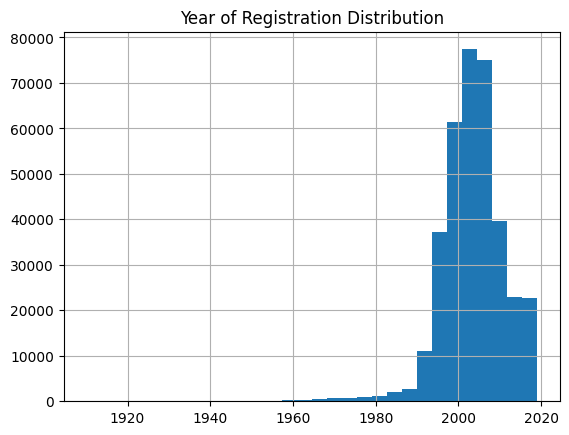

In [12]:
df['yearOfRegistration'].hist(bins=30)
plt.title("Year of Registration Distribution")
plt.show()


## 4. top 15 brand

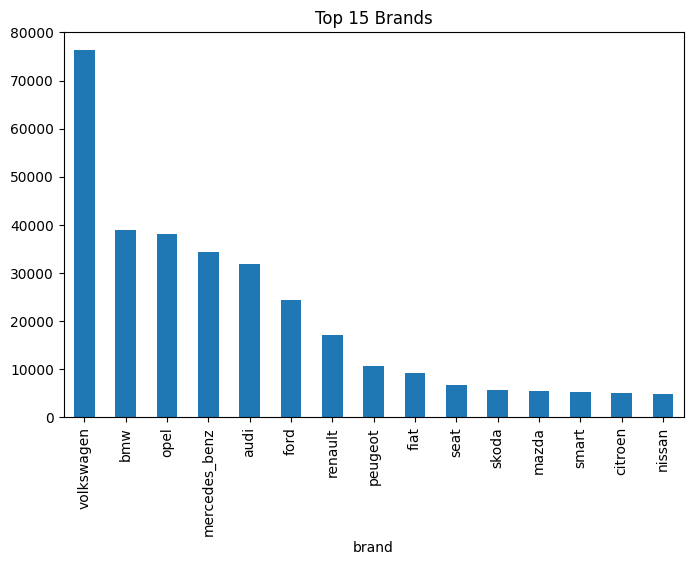

In [13]:
df['brand'].value_counts().head(15).plot(kind='bar', figsize=(8,5))
plt.title("Top 15 Brands")
plt.show()


## 5. size of test group

In [14]:
df['abtest'].value_counts(normalize=True)


abtest
test       0.518092
control    0.481908
Name: proportion, dtype: float64

## 6. groups comparation

In [15]:
df.groupby('abtest')['price'].describe()


,count,mean,std,min,25%,50%,75%,max
abtest,,,,,,,,
control,171955.0,5868.807729,7885.515069,101.0,1299.0,3100.0,7500.0,149999.0
test,184866.0,5903.003040,8041.023233,101.0,1299.0,3100.0,7500.0,149500.0


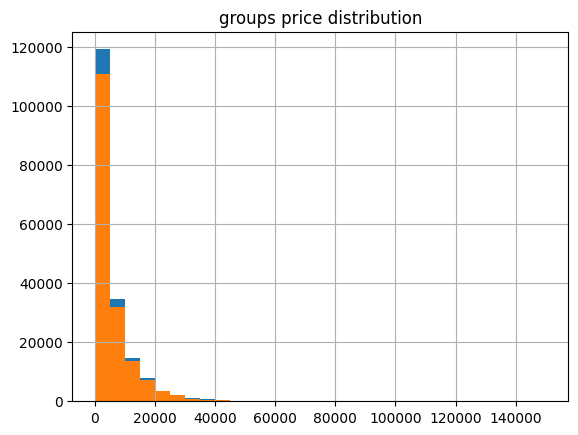

In [16]:
df[df['abtest']=='test']['price'].hist(bins=30)
df[df['abtest']=='control']['price'].hist(bins=30)
plt.title("groups price distribution")
plt.show()


The distribution of price in test and control group is similar, so the equality of data is good. Next step is check a/b test result.

# A/B test

## index1: average price difference （t-test）

In [17]:
test_group = df[df['abtest'] == 'test']['price']
control_group = df[df['abtest'] == 'control']['price']

t_stat, p_value = ttest_ind(test_group, control_group, equal_var=False)

print("Test group mean:", test_group.mean())
print("Control group mean:", control_group.mean())
print("T-test p value:", p_value)


Test group mean: 5903.003040039813
Control group mean: 5868.807728766247
T-test p value: 0.19981175544778335


## index2: duration difference (t-test)

In [18]:
# check whether test group and control group started at same time 
df.groupby('abtest')['dateCreated'].agg(['min','max','nunique'])

,min,max,nunique
abtest,,,
control,2015-08-07,2016-04-07,94
test,2014-03-10,2016-04-07,102


In [19]:
#ensure the start times of two groups are close to each other
df_filtered = df[df['dateCreated'] >= '2015-10-15']

In [20]:
df_filtered.groupby('abtest')['dateCreated'].agg(['min','max','nunique'])

,min,max,nunique
abtest,,,
control,2015-11-10,2016-04-07,91
test,2015-11-02,2016-04-07,96


In [21]:
test_d = df_filtered[df_filtered['abtest']=='test']['duration']
ctrl_d = df_filtered[df_filtered['abtest']!='test']['duration']

t_stat, p_value = ttest_ind(test_d, ctrl_d, equal_var=False)

print("Duration - Test mean:", test_d.mean())
print("Duration - Control mean:", ctrl_d.mean())
print("p value:", p_value)


Duration - Test mean: 8.886540552529224
Duration - Control mean: 8.829824602214572
p value: 0.047268524382159005


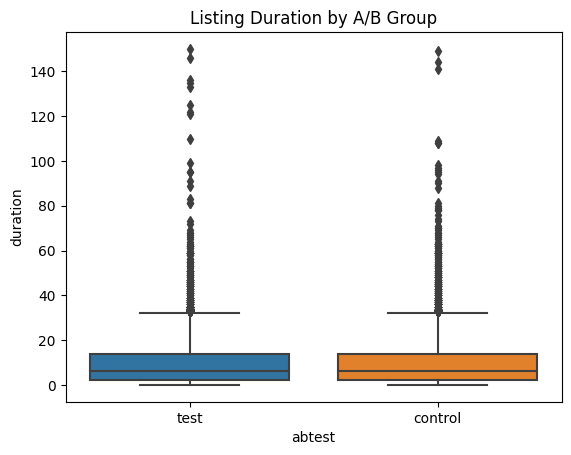

In [22]:
sns.boxplot(data=df_filtered, x='abtest', y='duration')
plt.title("Listing Duration by A/B Group")
plt.show()

## index3: vehicle brand difference(chi2-test)

In [23]:
top_brands = df['brand'].value_counts().head(15).index
df_top = df[df['brand'].isin(top_brands)]

cont = pd.crosstab(df_top['abtest'], df_top['brand'])
chi2, p, dof, exp = chi2_contingency(cont)

print("Brand distribution p value:", p)

Brand distribution p value: 0.9326783505876325


## index4: vehicle age difference (t-test)

In [24]:
df['current_year'] = df['lastSeen'].dt.year
df['car_age'] = df['current_year'] - df['yearOfRegistration']

df = df[(df['car_age'] >= 0) & (df['car_age'] <= 50)]

test_age = df[df['abtest']=='test']['car_age']
control_age = df[df['abtest']=='control']['car_age']

t_stat, p_value = ttest_ind(test_age, control_age, equal_var=False)
print("Test mean age:", test_age.mean())
print("Control mean age:", control_age.mean())
print("p-value:", p_value)

Test mean age: 12.944810320718119
Control mean age: 12.929973857715613
p-value: 0.5199912689725085


# Experimental Conclusion

## Average price difference

Because p = 0.2 > 0.05, the change of average price is not significant.

## Duration difference

p = 0.047 < 0.05, so the change of duration which means time gap from vehicle was published to deal is significant, transaction speed has increased due to the changes in the web.

## Vehicle brand difference 

p = 0.93 means the change in the web didn't bring significant change to brands of published cars.

## Vehicle age difference

p = 0.52 and both of two groups have same average vehicle age which is 12.9, means that the majority of published cars were used about 12.9 years.

## Summary

The changes of web didn't effect the quality of vehicles which were published. However, the transaction speed had significantly increased, that means new version of web is more effective.